In [22]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Differentiating quantum error mitigation transforms
===================================================

::: {.meta}
:property=\"og:description\": Differentiable error mitigation
:property=\"og:image\":
<https://pennylane.ai/qml/_images/diffable_mitigation_thumb.png>
:::

::: {.related}
tutorial\_error\_mitigation Error mitigation with Mitiq and PennyLane
:::

*Author: Korbinian Kottmann --- Posted: 22 August 2022.*

Error mitigation is an important strategy for minimizing noise when
using noisy-intermediate scale quantum (NISQ) hardware, especially when
designing and testing variational algorithms. In this demo, we will show
how error mitigation can be combined with variational workflows,
allowing you to differentiate [through]{.title-ref} the error
mitigation.

Differentiating quantum error mitigation transforms
---------------------------------------------------

Most variational quantum algorithms (VQAs) are concerned with optimizing
a [quantum function]{.title-ref},

$$f(\theta) = \langle 0 | U^\dagger(\theta) H U(\theta) | 0 \rangle,$$

for some Ansatz unitary $U$ with variational parameters $\theta$ and
observable $H$. These algorithms arose due to the constraints of noisy
near-term quantum hardware. This means that naturally in that scenario
we do not have direct access to $f$, but rather a noisy version $f^{⚡}$
where the variational state
$|\psi(\theta)\rangle = U^\dagger(\theta)|0\rangle$ is distorted via a
noise channel $\Phi(|\psi(\theta)\rangle \langle \psi(\theta)|)$. Since
noisy channels generally yield mixed states (see e.g.
`tutorial_noisy_circuits`{.interpreted-text role="doc"}), we can
formally write

$$f^{⚡}(\theta) := \text{tr}\left[H \Phi(|\psi(\theta)\rangle \langle \psi(\theta)|) \right].$$

To be able to get the most out of these devices, it is advisable to use
quantum error mitigation \-\-- a method of altering and/or
post-processing the quantum function $f^{⚡}(\theta)$ to improve the
result and be closer to the ideal scenario of an error free execution,
$f(\theta)$.

Formally, we can treat error mitigation as yet another transform that
maps the noisy quantum function $f^{⚡}$ to a new, mitigated, quantum
function $\tilde{f}$,

$$\text{mitigate}: f^{⚡} \mapsto \tilde{f}.$$

In order to run our VQA with our mitigated quantum function, we need to
ensure that $\tilde{f}$ is differentiable \-\-- both formally and
practically in our implementation. PennyLane now provides one such
differentiable quantum error mitigation technique with [zero noise
extrapolation]{.title-ref} (ZNE), which can be used and differentiated
in simulation and on hardware. Thus, we can improve the estimates of
observables without breaking the differentiable workflow of our
variational algorithm. We will briefly introduce these functionalities
and afterwards go more in depth to explore what happens under the hood.

We start by initializing a noisy device under the
`~.pennylane.DepolarizingChannel`{.interpreted-text role="class"}:


In [23]:
import pennylane as qml
import pennylane.numpy as np
from pennylane.transforms import mitigate_with_zne

from matplotlib import pyplot as plt

n_wires = 4
np.random.seed(1234)

# Describe noise
noise_gate = qml.DepolarizingChannel
noise_strength = 0.05

# Load devices
dev_ideal = qml.device("default.mixed", wires=n_wires)
dev_noisy = qml.transforms.insert(noise_gate, noise_strength, position="all")(dev_ideal)

We are going to use the transverse field Ising model Hamiltonian
$H = - \sum_i X_i X_{i+1} + 0.5 \sum_i Z_i$ as our observable:


In [24]:
coeffs = [1.0] * (n_wires - 1) + [0.5] * n_wires
observables = [qml.PauliX(i) @ qml.PauliX(i + 1) for i in range(n_wires - 1)]
observables += [qml.PauliZ(i) for i in range(n_wires)]

H = qml.Hamiltonian(coeffs, observables)

The quantum function, the expectation value of $H$, can then be executed
on the noisy or ideal device by creating respective QNodes for both. As
our ansatz, we\'ll use a
`~.pennylane.SimplifiedTwoDesign`{.interpreted-text role="class"} with
all-constant parameters set to `1`:


In [25]:
n_layers = 2

w1 = np.ones((n_wires), requires_grad=True)
w2 = np.ones((n_layers, n_wires - 1, 2), requires_grad=True)

def qfunc(w1, w2):
    qml.SimplifiedTwoDesign(w1, w2, wires=range(n_wires))
    return qml.expval(H)

qnode_noisy = qml.QNode(qfunc, dev_noisy)
qnode_ideal = qml.QNode(qfunc, dev_ideal)

We can then simply transform the noisy QNode $f^{⚡}$ with
`~.pennylane.transforms.mitigate_with_zne`{.interpreted-text
role="func"} to generate $\tilde{f}$. If everything goes as planned,
executing the mitigated QNode is then closer to the ideal result:


In [49]:
scale_factors = [1, 2, 3, 4]


qnode_mitigated = mitigate_with_zne(
    scale_factors=scale_factors,
    folding=qml.transforms.fold_global,
    extrapolate=qml.transforms.richardson_extrapolate,
)(qnode_noisy)

print("Ideal QNode: ", qnode_ideal(w1, w2))
print("Mitigated QNode: ", qnode_mitigated(w1, w2))
print("Noisy QNode: ", qnode_noisy(w1, w2))

Ideal QNode:  0.7786752842284947
Mitigated QNode:  0.6774632462395456
Noisy QNode:  0.30459632191309644


In [47]:
print (len(w1))
print (len(w2))

4
2


The transforms provided for the `folding` and `extrapolate` arguments
can be treated as default black boxes for the moment. We will explain
them in more detail in the following section.

The cool thing about this new mitigated QNode is that it is still
differentiable! That is, we can compute its gradient as usual:


In [28]:
grad = qml.grad(qnode_mitigated)(w1, w2)
print(grad[0])
print(grad[1])

[-0.33653982  0.3013485   0.3013485  -0.33653982]
[[[ 0.26542579  0.60293771]
  [ 0.60293771  0.26542579]
  [ 0.04071575  0.04071575]]

 [[-0.45149957  0.28565882]
  [ 0.28565882 -0.45149957]
  [-0.00354822 -0.00354822]]]


Under the hood of Zero Noise Extrapolation
==========================================

What is happening here under the hood? The basic idea of ZNE is to
artificially increase the noise in a circuit, controlled by a parameter
$\lambda$ that is called the `scale_factor`, to then be able to
extrapolate back to zero noise.

Consider two circuits: $U$ and $U U^\dagger U$. They are logically
equivalent, but we can expect the latter to have more noise due its
larger gate count. This is the underlying concept of unitary folding,
which is used to artificially increase the noise of a quantum function.
Given a unitary circuit $U = L_d .. L_1$, where $L_i$ can be either a
gate or layer, we use
`~.pennylane.transforms.fold_global`{.interpreted-text role="func"} to
construct

$$\texttt{fold_global}(U) = U (U^\dagger U)^n (L^\dagger_d L^\dagger_{d-1} .. L^\dagger_s) (L_s .. L_d),$$

where $n = \lfloor (\lambda - 1)/2 \rfloor$ and
$s = \lfloor \left((\lambda -1) \mod 2 \right) (d/2) \rfloor$ are
determined via the `scale_factor` $\lambda$.

The version of ZNE that we are showcasing is simply executing the noisy
quantum function $f^{⚡}$ for different scale factors, and then
extrapolate to $\lambda \rightarrow 0$ (zero noise). This is done with a
polynomial fit in $f^{⚡}$ as a function of $\lambda$. Note that
`scale_factor = 1` corresponds to the original circuit, i.e. the noisy
execution.


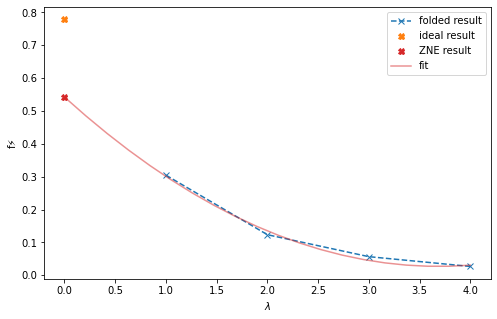

In [50]:
scale_factors = [1, 2, 3, 4]
folded_res = [
    qml.transforms.fold_global(qnode_noisy, lambda_)(w1, w2) for lambda_ in scale_factors
]

ideal_res = qnode_ideal(w1, w2)

# coefficients are ordered like
# coeffs[0] * x**2 + coeffs[1] * x + coeffs[0]
# i.e. fitted_func(0)=coeff[-1]
coeffs = np.polyfit(scale_factors, folded_res, 2)
zne_res = coeffs[-1]

x_fit = np.linspace(0, scale_factors[-1], 20)
y_fit = np.polyd(coeffs)(x_fit)

plt.figure(figsize=(8, 5))
plt.plot(scale_factors, folded_res, "x--", label="folded result")
plt.plot(0, ideal_res, "X", label="ideal result")
plt.plot(0, zne_res, "X", label="ZNE result", color="tab:red")
plt.plot(x_fit, y_fit, label="fit", color="tab:red", alpha=0.5)
plt.xlabel("$\\lambda$")
plt.ylabel("f⚡")
plt.legend()
plt.show()

We see that the mitigated result comes close to the ideal result,
whereas the noisy result is further off (see value at `scale_factor=1`).

Note that this folding scheme is relatively simple and only really is
sensible for integer values of `scale_factor`. At the same time,
`scale_factor` is limited from above by the noise as the noisy quantum
function quickly decoheres under this folding. I.e., for $\lambda\geq 4$
the results are typically already decohered. Therefore, one typically
only uses `scale_factors = [1, 2, 3]`. In principle, one can think of
more fine grained folding schemes and test them by providing custom
folding operations. How this can be done in PennyLane with the given API
is described in
`~.pennylane.transforms.mitigate_with_zne`{.interpreted-text
role="func"}.

Note that Richardson extrapolation, which we used to define the
`mitigated_qnode`, is just a fancy way to describe a polynomial fit of
`order = len(x) - 1`. Alternatively, you can use
`~.pennylane.transforms.poly_extrapolate`{.interpreted-text role="func"}
and manually pass the order via a keyword argument
`extrapolate_kwargs={'order': 2}`.

Differentiable mitigation in a variational quantum algorithm
============================================================

We will now use mitigation while we optimize the parameters of our
variational circuit to obtain the ground state of the Hamiltonian \-\--
this is the variational quantum eigensolving (VQE), see
`tutorial_vqe`{.interpreted-text role="doc"}. Then, we will compare VQE
optimization runs for the ideal, noisy, and mitigated QNodes and see
that the mitigated one comes close to the ideal (zero noise) results,
whereas the noisy execution is further off.


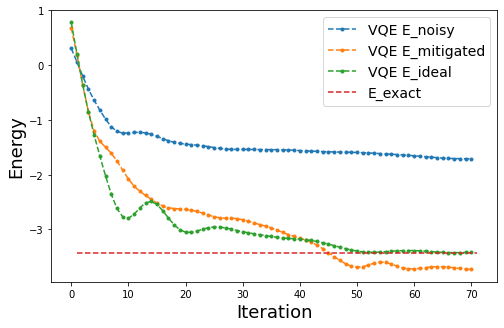

In [51]:
def VQE_run(cost_fn, max_iter, stepsize=0.1):
    """VQE Optimization loop"""
    opt = qml.AdamOptimizer(stepsize=stepsize)

    # fixed initial guess
    w1 = np.ones((n_wires), requires_grad=True)
    w2 = np.ones((n_layers, n_wires - 1, 2), requires_grad=True)

    energy = []

    # Optimization loop
    for _ in range(max_iter):
        (w1, w2), prev_energy = opt.step_and_cost(cost_fn, w1, w2)

        energy.append(prev_energy)

        
    energy.append(cost_fn(w1, w2))

    return energy


max_iter = 70

energy_ideal = VQE_run(qnode_ideal, max_iter)
energy_noisy = VQE_run(qnode_noisy, max_iter)
energy_mitigated = VQE_run(qnode_mitigated, max_iter)

energy_exact = np.min(np.linalg.eigvalsh(qml.matrix(H)))

plt.figure(figsize=(8, 5))
plt.plot(energy_noisy, ".--", label="VQE E_noisy")
plt.plot(energy_mitigated, ".--", label="VQE E_mitigated")
plt.plot(energy_ideal, ".--", label="VQE E_ideal")
plt.plot([1, max_iter + 1], [energy_exact] * 2, "--", label="E_exact")
plt.legend(fontsize=14)
plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Energy", fontsize=18)
plt.show()

We see that during the optimization we are for the most part
significantly closer to the ideal simulation and end up with a better
energy compared to executing the noisy device without ZNE.

So far we have been using PennyLane gradient methods that use `autograd`
for simulation and `parameter-shift` rules for real device executions.
We can also use the other interfaces that are supported by PennyLane,
`jax`, `torch` and `tensorflow`, in the usual way as described in the
interfaces section of the documentation
`introduction/interfaces`{.interpreted-text role="doc"}.

Differentiating the mitigation transform itself
===============================================

In the previous sections, we have been concerned with differentiating
[through]{.title-ref} the mitigation transform. An interesting direction
for future work is differentiating the transform itself[^1]. In
particular, the authors in[^2] make the interesting observation that for
some error mitigation schemes, the cost function is smooth in some of
the mitigation parameters. Here, we show one of their examples, which is
a time-sensitive dynamical decoupling scheme:

![Time-sensitive dynamical decoupling
scheme.](/demonstrations/diffable-mitigation/Mitigate_real_vs_sim3.png){.align-center
width="50.0%"}

In this mitigation technique, the single qubit state is put into an
equal superposition: $|+\rangle = (|0\rangle + |1\rangle)/\sqrt{2}$.
During the first idle time $t_1$, the state is altered due to noise.
Applying $X$ reverses the roles of each computational basis state. The
idea is that the noise in the second idle time $T-t_1$ is cancelling out
the effect of the first time window. We see that the output fidelity is
a smooth function of $t_1$. This was executed on `ibm_perth`, and we
note that simple noise models, like the simulated IBM device, do not
suffice to reproduce the behavior of the real device.

Obtaining the gradient with respect to this parameter is difficult.
Formally, writing down the derivative of this transform with respect to
the idle time in order to derive its parameter-shift rules would require
access to the noise model. This is very difficult for a realistic
scenario. Further, most mitigation parameters are integers and would
have to be smoothed in a differentiable way. A simple but effective
strategy is using finite differences for the gradient with respect to
mitigation parameters.

Overall, this is a nice example of a mitigation scheme where varying the
mitigation parameter has direct impact to the simulation result. It is
therefore desirable to be able to optimize this parameter at the same
time as we perform a variational quantum algorithm.

Conclusion
==========

We demonstrated how zero-noise extrapolation can be seamlessly
incorporated in a differentiable workflow in PennyLane to achieve better
results. Further, the possibility of differentiating error mitigation
transforms themselves has been discussed and we have seen that some
mitigation schemes require execution on real devices or more advanced
noise simulations.

References
==========

About the author
================

[^1]: Olivia Di Matteo, Josh Izaac, Tom Bromley, Anthony Hayes,
    Christina Lee, Maria Schuld, Antal Száva, Chase Roberts, Nathan
    Killoran. \"Quantum computing with differentiable quantum
    transforms.\" [arXiv:2202.13414](https://arxiv.org/abs/2202.13414),
    2021.

[^2]: Gokul Subramanian Ravi, Kaitlin N. Smith, Pranav Gokhale, Andrea
    Mari, Nathan Earnest, Ali Javadi-Abhari, Frederic T. Chong. \"VAQEM:
    A Variational Approach to Quantum Error Mitigation.\"
    [arXiv:2112.05821](https://arxiv.org/abs/2112.05821), 2021.
